In [37]:
import numpy as np
from ax import ParameterType, RangeParameter, SearchSpace, SimpleExperiment, modelbridge
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.utils.notebook.plotting import render, init_notebook_plotting

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
init_notebook_plotting()

[INFO 12-09 18:32:05] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


In [3]:
def branin(x1, x2):
    y = (x2 - 5.1/(4*np.pi**2) * x1**2 + 5 * x1/np.pi - 6)**2
    y += 10 * (1 - 1/(8*np.pi)) * np.cos(x1) + 10
    return y

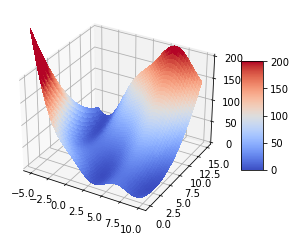

In [40]:
X,Y = np.meshgrid(np.arange(-5,10,.1), np.arange(0,15,.1))
fig = plt.figure()
ax = fig.gca(projection='3d')
from matplotlib import cm
from matplotlib.colors import Normalize
surf = ax.plot_surface(X,Y,branin(X,Y), linewidth=0, cmap=cm.coolwarm, antialiased=False, norm=Normalize(0,200))
ax.set_zlim(0,200)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [4]:
def evaluate(parameterization, weight=None):
    x1,x2 = parameterization['x1'], parameterization['x2']
    return {'branin': (branin(x1,x2), 0.0)}

In [5]:
search_space = SearchSpace(
    parameters=[
        RangeParameter(name='x1', parameter_type=ParameterType.FLOAT, lower=-5, upper=10),
        RangeParameter(name='x2', parameter_type=ParameterType.FLOAT, lower=0, upper=15)
    ]
)

In [6]:
exp = SimpleExperiment(
    name='test_branin',
    search_space=search_space,
    evaluation_function=evaluate,
    objective_name='branin',
    minimize=True
)

In [ ]:
sobol = modelbridge.get_sobol(exp.search_space)
for _ in range(5):
    exp.new_trial(generator_run=sobol.gen(1))
print('Sobol initialization complete')
for _ in range(15):
    gpei = modelbridge.get_GPEI(experiment=exp, data=exp.eval())
    batch = exp.new_trial(generator_run=gpei.gen(1))
print('GP+EI optimization complete')

In [8]:
exp.eval().df

arm_name metric_name        mean  sem  trial_index
0       0_0      branin   26.798116  0.0            0
1       1_0      branin   14.817459  0.0            1
2       2_0      branin  123.916141  0.0            2
3       3_0      branin   20.710570  0.0            3
4       4_0      branin   81.261694  0.0            4
5       5_0      branin   44.440874  0.0            5
6       6_0      branin  123.078937  0.0            6
7       7_0      branin    5.404632  0.0            7
8       8_0      branin    1.168413  0.0            8
9       9_0      branin   13.577127  0.0            9
10     10_0      branin   40.061889  0.0           10
11     11_0      branin   18.587228  0.0           11
12     12_0      branin   18.872423  0.0           12
13     13_0      branin    5.599533  0.0           13
14     14_0      branin   14.238214  0.0           14
15     15_0      branin   18.167948  0.0           15
16     16_0      branin   10.960889  0.0           16
17     17_0      branin    3.033227  0.0           17
18     18_0      branin    4.434486  0.0           18
19     19_0      branin    2.052327  0.0           19

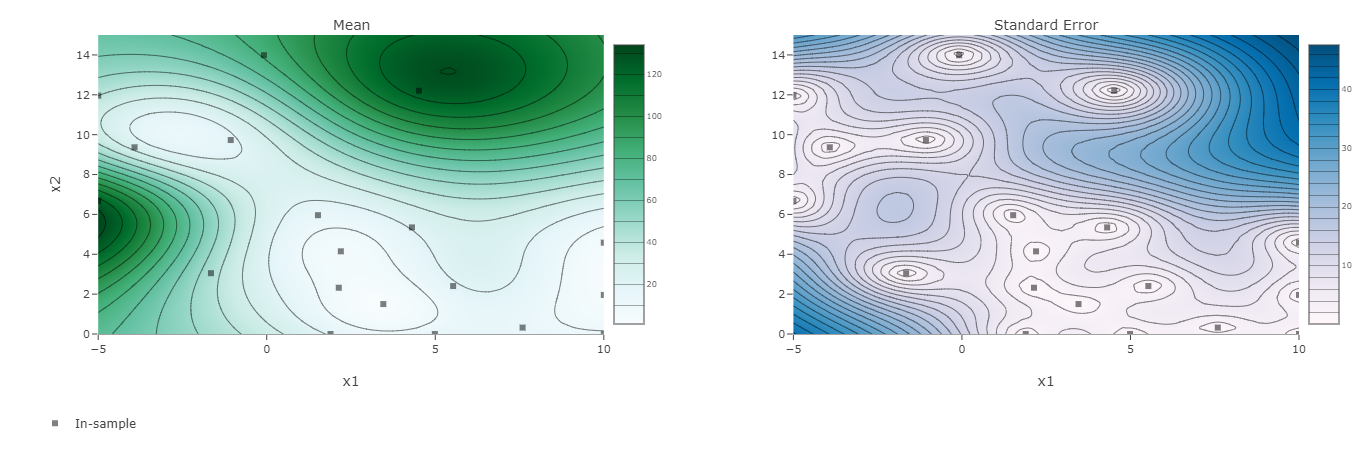

In [9]:
render(plot_contour(model=gpei, param_x='x1', param_y='x2', metric_name='branin', relative=False))

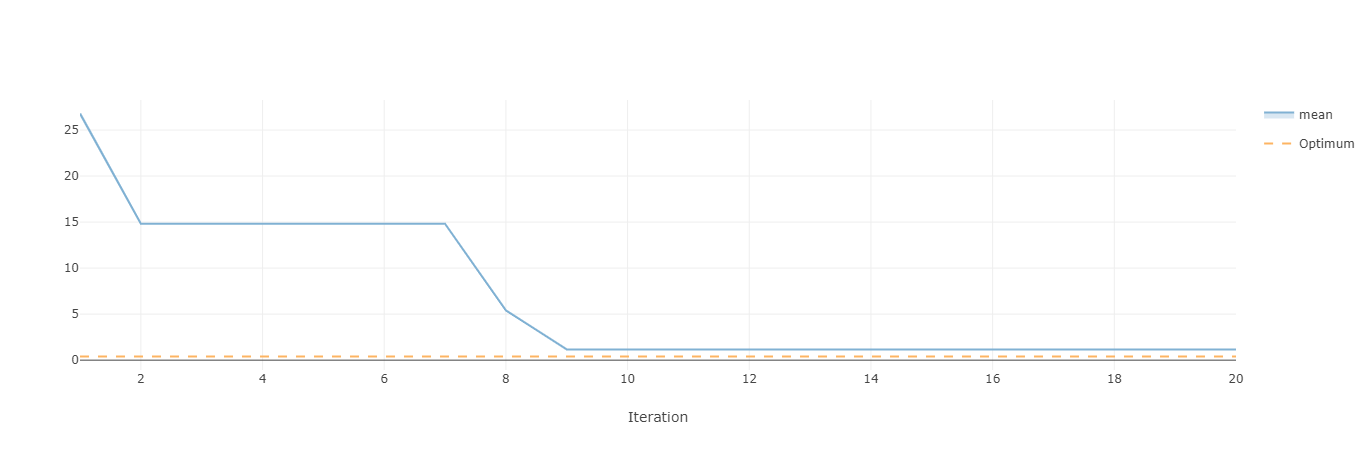

In [10]:
best_objectives = np.array([[trial.objective_mean for trial in exp.trials.values()]])
best_obj_plot = optimization_trace_single_method(y=np.minimum.accumulate(best_objectives,axis=1), optimum=0.397887)
render(best_obj_plot)

# Reflection

I feel that this problem, while fairly easy (especially if you have any experience with Ax) is very useful, as it serves as a solid framework for actually applying BayesOpt in practice. It also covers most of the scope of what we have learned, but isn't overcomplicated by requiring implementation of acquisition functions, optimization loops, etc.